# Regression example with a neural network

## Prepare data

In [34]:
import pickle
import gzip
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [35]:
with gzip.open("rec_hist_pt_25.pkl.gz") as f:
    rec = pickle.load(f)

with gzip.open("gen_hist_pt_25.pkl.gz") as f:
    gen = pickle.load(f)

# fix for divide by zero
gen.values()[gen.values() == 0] = 1

n = gen.values()
ns = rec.values()
# fix for rec > n
ns = np.where(ns > n, n, ns)
nf = n - ns

X = []
ysf = []
for ieta, eta in enumerate(rec.axes[0].centers):
    for ipt, pt in enumerate(rec.axes[1].centers):
        for iphi, phi in enumerate(rec.axes[2].centers):
            for ich, _ in enumerate(rec.axes[3]):
                for isp, _ in enumerate(rec.axes[4]):
                    X.append((eta, np.log(pt), np.cos(phi), np.sin(phi), ich, isp))
                    ysf.append((ns[ieta, ipt, iphi, ich, isp], nf[ieta, ipt, iphi, ich, isp]))

X0 = np.array(X).astype(np.float32)
ysf = np.array(ysf).astype(np.float32)
y = ysf[:, 0] / np.sum(ysf, axis=1)

scaler = StandardScaler()
scaler.fit(X0)

X = scaler.transform(X0)

print("data points", X.shape[0])

data points 14400


## Scikit-Learn

It turns out that the simple MLPRegressor in Scikit-Learn works very well on small datasets.

In [36]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error

clf = MLPRegressor(
    hidden_layer_sizes=(2**6,) * 4,
    batch_size=1000,
    alpha=0,
    tol=1e-6,
    max_iter=1000,
    verbose=1,
)

clf.fit(X, y)

# coefficients only available after training
n = 0
for c in clf.coefs_:
    n += np.prod(c.shape)
for c in clf.intercepts_:
    n += c.shape[0]
print("number of parameters", n)

print("MLPRegressor", mean_squared_error(clf.predict(X), y))

Iteration 1, loss = 0.13524968
Iteration 2, loss = 0.04595863
Iteration 3, loss = 0.02695522
Iteration 4, loss = 0.01962149
Iteration 5, loss = 0.01478888
Iteration 6, loss = 0.01155254
Iteration 7, loss = 0.00932112
Iteration 8, loss = 0.00774466
Iteration 9, loss = 0.00665458
Iteration 10, loss = 0.00582129
Iteration 11, loss = 0.00512440
Iteration 12, loss = 0.00461393
Iteration 13, loss = 0.00412385
Iteration 14, loss = 0.00371786
Iteration 15, loss = 0.00347114
Iteration 16, loss = 0.00319352
Iteration 17, loss = 0.00300758
Iteration 18, loss = 0.00282326
Iteration 19, loss = 0.00268644
Iteration 20, loss = 0.00256302
Iteration 21, loss = 0.00245451
Iteration 22, loss = 0.00233848
Iteration 23, loss = 0.00224269
Iteration 24, loss = 0.00217735
Iteration 25, loss = 0.00212162
Iteration 26, loss = 0.00202550
Iteration 27, loss = 0.00197976
Iteration 28, loss = 0.00196378
Iteration 29, loss = 0.00187424
Iteration 30, loss = 0.00177460
Iteration 31, loss = 0.00172791
Iteration 32, los

In [37]:
def draw(model):
    labels = ("π", "K", "p", "other")
    for phii in rec.axes[2].centers[:]:
        if phii < 0:
            continue
        fig, axes = plt.subplots(3, 2, sharex=True, sharey=True, layout="compressed")
        plt.suptitle(rf"$\phi = {np.degrees(phii):.0f}$ deg")
        for etai, axi in zip(rec.axes[0].centers, axes.flat):
            plt.sca(axi)
            for ich, charge in enumerate((-1, 1)):
                for isp, label in enumerate(labels):
                    ma = X0[:, 0] == etai
                    ma &= X0[:, 2] == np.cos(phii)
                    ma &= X0[:, 3] == np.sin(phii)
                    ma &= X0[:, 4] == ich
                    ma &= X0[:, 5] == isp
                    plt.plot(np.exp(X0[ma, 1]), charge * y[ma], "o", ms=4, color=f"C{isp}", label=f"{label}" if ich else None)

                    mpt = np.geomspace(10, 1e4, 2000)
                    Xp = np.empty((len(mpt), 6), dtype=np.float32)
                    Xp[:, 0] = etai
                    Xp[:, 1] = np.log(mpt)
                    Xp[:, 2] = np.cos(phii)
                    Xp[:, 3] = np.sin(phii)
                    Xp[:, 4] = ich
                    Xp[:, 5] = isp
                    yp = model(scaler.transform(Xp))
                    plt.plot(np.exp(Xp[:, 1]), charge * yp, color=f"C{isp}")
        plt.sca(axes[0,0])
        plt.semilogx()
        plt.ylim(-1.1, 1.1)
        plt.legend(fontsize="xx-small", ncol=2, frameon=False);

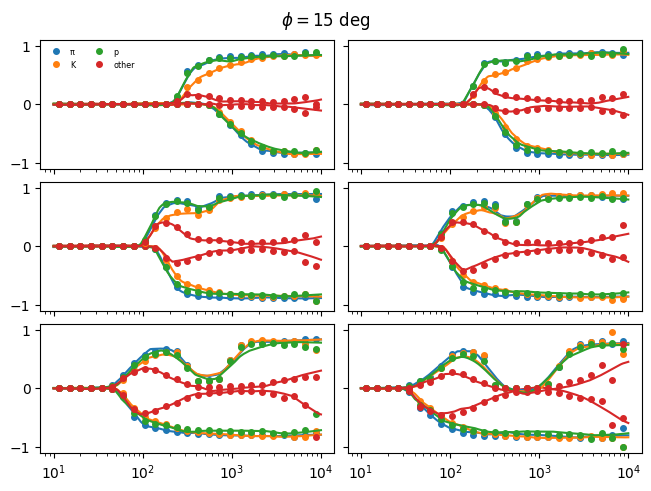

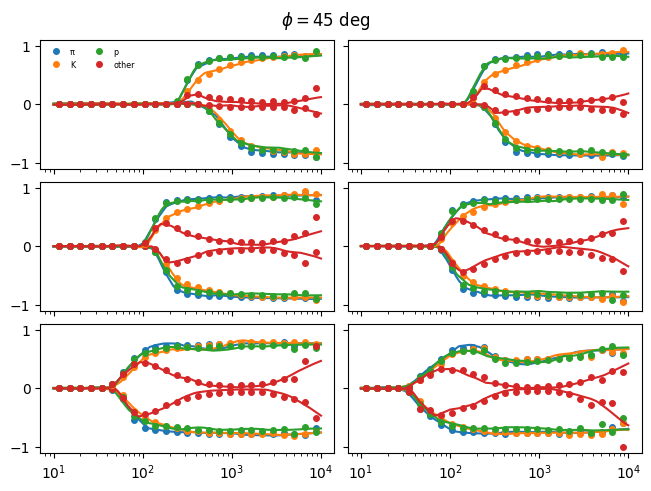

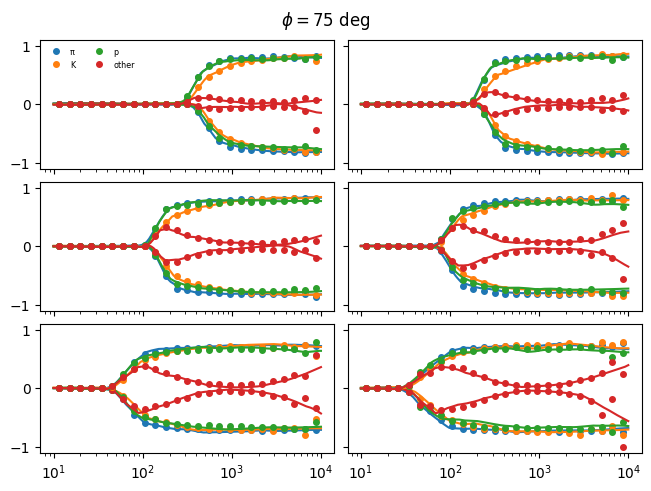

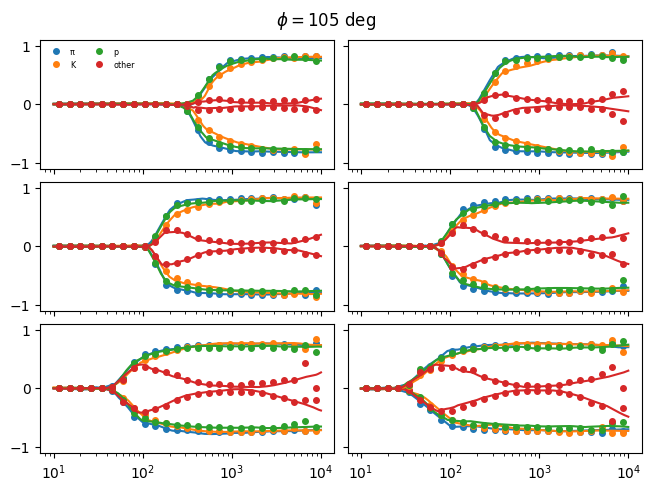

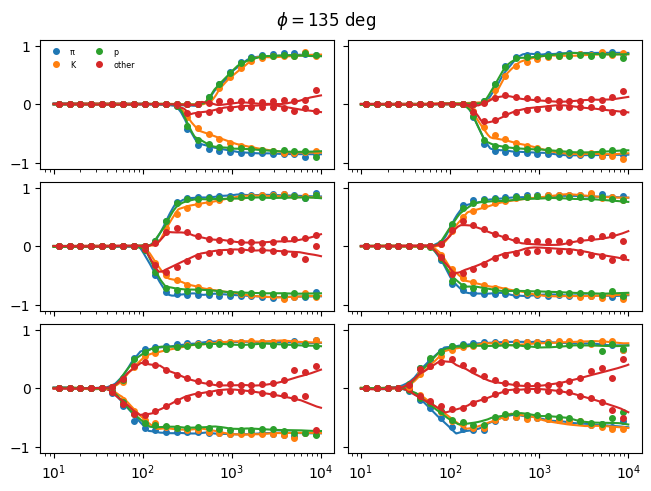

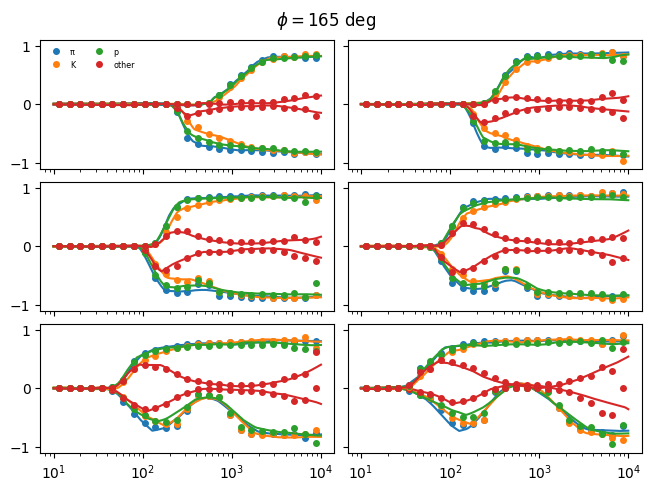

In [38]:
draw(clf.predict)

## PyTorch

number of parameters 12993
epoch 1 loss 0.2605130076408386
epoch 100 loss 0.012227535247802734
epoch 200 loss 0.004112111870199442
epoch 300 loss 0.0025720775593072176
Epoch 00398: reducing learning rate of group 0 to 8.0000e-04.
epoch 400 loss 0.0019067629473283887
epoch 500 loss 0.0016411709366366267
Epoch 00542: reducing learning rate of group 0 to 6.4000e-04.
epoch 600 loss 0.0014778061304241419
epoch 700 loss 0.0013670572079718113
Epoch 00749: reducing learning rate of group 0 to 5.1200e-04.
epoch 800 loss 0.0012851639185100794
epoch 900 loss 0.0012269362341612577
epoch 1000 loss 0.0011803213274106383
Epoch 01010: reducing learning rate of group 0 to 4.0960e-04.
epoch 1100 loss 0.0011385021498426795
epoch 1200 loss 0.001103899790905416
Epoch 01246: reducing learning rate of group 0 to 3.2768e-04.
epoch 1300 loss 0.0010764816543087363
epoch 1400 loss 0.0010533668100833893
epoch 1500 loss 0.0010305356699973345
Epoch 01547: reducing learning rate of group 0 to 2.6214e-04.
epoch 1600 

[]

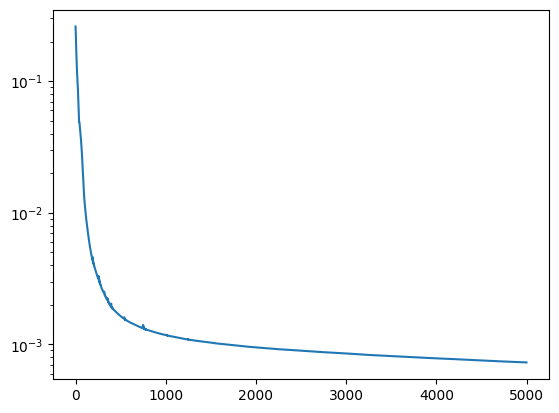

In [39]:
import torch
from torch import nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim import Adam

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_device(device)
torch.set_default_dtype(torch.float32)

nonlin = nn.ReLU()
num = 2**6
torch_model = nn.Sequential(
    nn.Linear(6, num),
    nonlin,
    nn.Linear(num, num),
    nonlin,
    nn.Linear(num, num),
    nonlin,
    nn.Linear(num, num),
    nonlin,
    nn.Linear(num, 1),
    # adding a ReLU here makes training unstable
    nn.Flatten(0, 1),
)

n = 0
for par in torch_model.parameters():
    n += np.prod(par.shape)
print("number of parameters", n)

# must make copies here
torch_X = torch.tensor(X.copy())
torch_y = torch.tensor(y.copy())

max_epoch = 5000
shrink_patience = 10
abort_patience = 100
learning_rate = 1e-3
learning_rate_shrink_factor = 0.8
tol = 1e-6

loss_fn = nn.MSELoss()
opt = Adam(torch_model.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(
    opt, patience=shrink_patience, factor=learning_rate_shrink_factor, verbose=True
)

losses = []
no_improvement_below_tolerance = 0
prev_loss = np.inf
for epoch in range(1, max_epoch + 1):
    y_pred = torch_model(torch_X)
    loss = loss_fn(y_pred, torch_y)
    opt.zero_grad()
    loss.backward()
    opt.step()
    scheduler.step(loss)

    loss = loss.item()
    losses.append(loss)
    if epoch == 1 or epoch % 100 == 0:
        print("epoch", epoch, "loss", loss)

    if loss < prev_loss - tol:
        no_improvement_below_tolerance = 0
        prev_loss = loss
    else:
        no_improvement_below_tolerance += 1
    if no_improvement_below_tolerance > abort_patience:
        break

plt.plot(losses)
plt.semilogy()

In [40]:
print("MLPRegressor", mean_squared_error(clf.predict(X), y))
print("PyTorch     ", mean_squared_error(torch_model(torch_X).detach().numpy(), y))

MLPRegressor 0.0012928459
PyTorch      0.0007299928


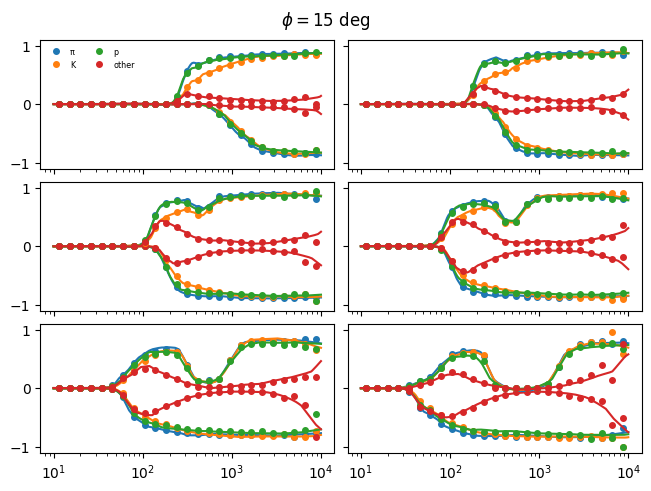

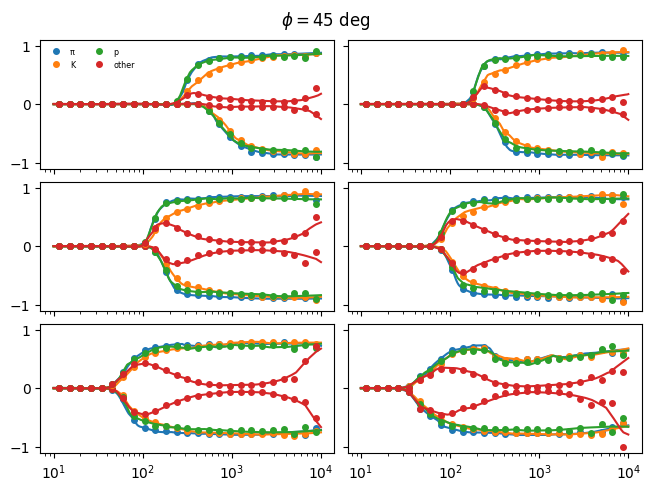

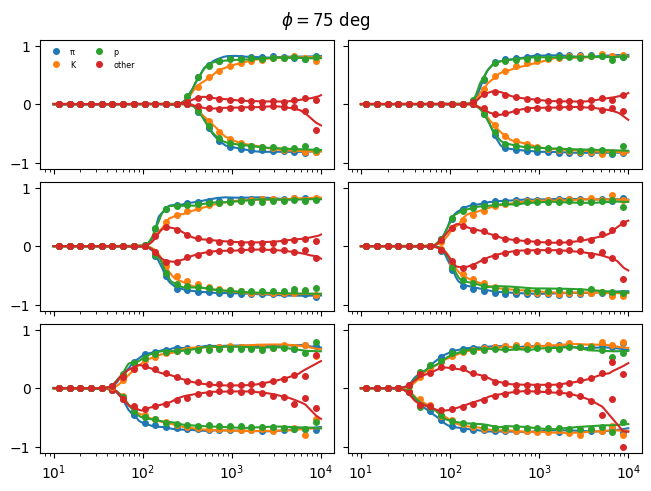

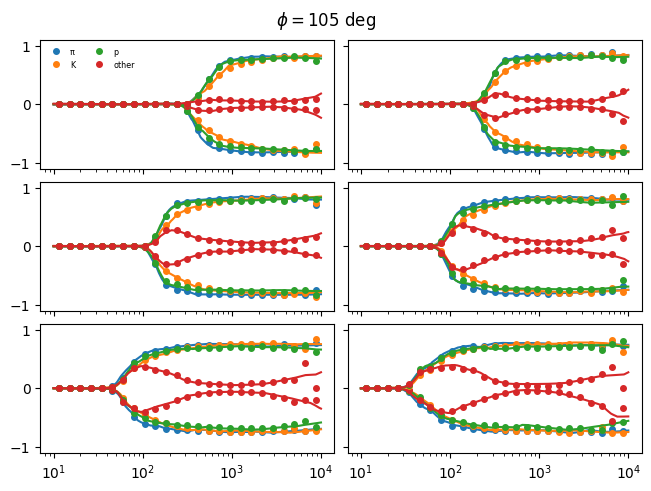

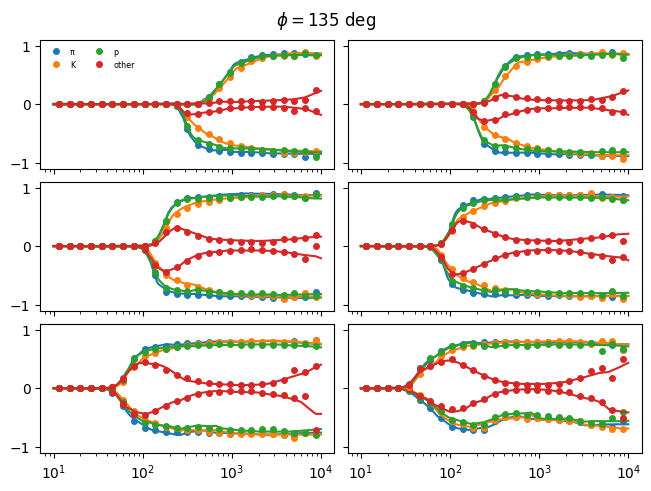

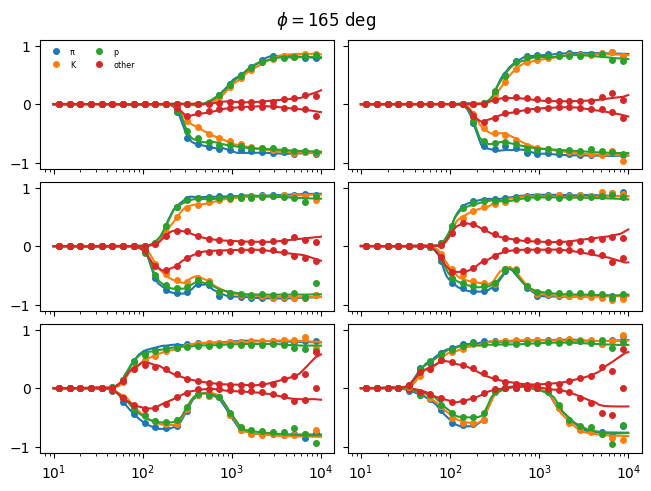

In [41]:
draw(lambda x: torch_model(torch.tensor(x)).detach().numpy())

## Flax / JAX

Flax with JAX is a modern functional programming library which is great for trying out new things. It comes with fewer high-level objects than PyTorch. Where PyTorch offers ReduceLROnPlateau, need to implement something analog from scratch.

JAX process: 0 / 1
JAX local devices: [CpuDevice(id=0)]
number of parameters 12993
epoch 1 loss=0.08076246827840805
epoch 100 loss=0.0020129727199673653
epoch 183 learning rate=0.00800000037997961
epoch 200 loss=0.0011017167707905173
epoch 249 learning rate=0.006400000303983688
epoch 300 loss=0.0007821371546015143
epoch 400 loss=0.0006839827983640134
epoch 403 learning rate=0.005120000336319208
epoch 500 loss=0.0006046906346455216
epoch 537 learning rate=0.0040960004553198814
epoch 600 loss=0.0005689435638487339
epoch 700 loss=0.0005448783631436527
epoch 705 learning rate=0.0032768005039542913
epoch 800 loss=0.0005218674195930362
epoch 900 loss=0.0005037999362684786
epoch 903 learning rate=0.002621440449729562
epoch 1000 loss=0.0004878745530731976
epoch 1100 loss=0.000474917032988742
epoch 1145 learning rate=0.002097152406349778
epoch 1200 loss=0.00046101928455755115
epoch 1300 loss=0.0004500017676036805
epoch 1382 learning rate=0.0016777219716459513
epoch 1400 loss=0.00043911702232435

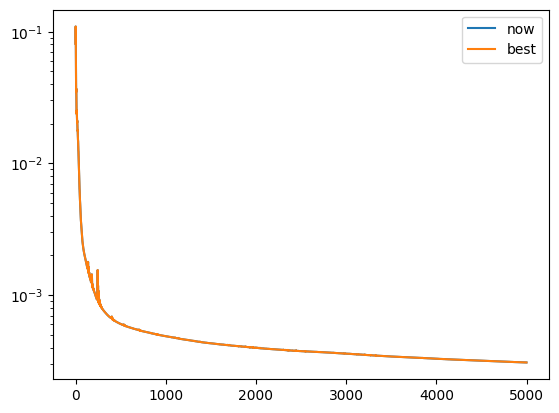

In [63]:
from typing import Callable, Iterable
from ml_collections import ConfigDict
import jax
from jax import numpy as jnp
from flax import linen as nn
import optax


class Model(nn.Module):
    sizes: Iterable[int]  # Number of hidden neurons
    nonlin: Callable

    @nn.compact  # Tells Flax to look for defined submodules
    def __call__(self, x):
        for size in self.sizes:
            x = nn.Dense(size)(x)
            x = self.nonlin(x)
        return nn.Dense(1)(x).flatten()


def train(config: ConfigDict, x, y):
    x = jax.device_put(x)
    y = jax.device_put(y)

    model = Model(config.layers, config.nonlin)

    @jax.jit
    def loss_fn(theta, x, y):
        y_pred = model.apply(theta, x)
        # return jnp.mean(jnp.square(y - y_pred))
        return jnp.mean(optax.huber_loss(y, y_pred))

    key1, key2 = jax.random.split(jax.random.PRNGKey(0))
    theta = model.init(key2, jax.random.normal(key1, x.shape[1:]))

    n = 0
    for layer in theta["params"].values():
        n += np.prod(layer["kernel"].shape) + layer["bias"].shape[0]
    print("number of parameters", n)

    tx = optax.inject_hyperparams(optax.adabelief)(learning_rate=config.learning_rate)
    state = tx.init(theta)
    loss_grad_fn = jax.value_and_grad(loss_fn)

    losses = []
    prev_loss = np.inf
    epochs_without_improvement = 0
    for epoch in range(1, config.max_epoch + 1):

        loss, grads = loss_grad_fn(theta, x, y)
        updates, state = tx.update(grads, state)
        theta = optax.apply_updates(theta, updates)

        losses.append(loss)

        if epoch == 1 or epoch % config.print_freq == 0:
            print(f"epoch {epoch} loss={loss}")

        if loss < prev_loss:
            epochs_without_improvement = 0
            prev_loss = loss
        else:
            epochs_without_improvement += 1
        if epochs_without_improvement >= config.shrink_patience:
            state.hyperparams["learning_rate"] *= config.learning_rate_shrink_factor
            print(f"epoch {epoch } learning rate={state.hyperparams['learning_rate']}")
            epochs_without_improvement = 0
            continue
        if state.hyperparams["learning_rate"] < config.tolerance:
            break

    return model, theta, losses

print(f"JAX process: {jax.process_index()} / {jax.process_count()}")
print(f"JAX local devices: {jax.local_devices()}")

config = ConfigDict()
config.layers = (2 ** 6,) * 4
config.nonlin = nn.relu
config.max_epoch = 5000
config.learning_rate = 1e-2
config.shrink_patience = 10
config.learning_rate_shrink_factor = 0.8
config.print_freq = 100
config.tolerance = 1e-6

prev_losses = locals().get("prev_losses", None)

flax_model, flax_theta, losses = train(config, X, y)

best_losses = locals().get("best_losses", losses)
if best_losses[-1] < losses[-1]:
    best_losses = losses

plt.plot(losses, label="now")
if prev_losses is not None:
    plt.plot(prev_losses, label="previous")
plt.plot(best_losses, label="best")
plt.legend()
plt.semilogy();

In [64]:
print("MLPRegressor", mean_squared_error(clf.predict(X), y))
print("PyTorch     ", mean_squared_error(torch_model(torch_X).detach().numpy(), y))
print("Flax        ", mean_squared_error(flax_model.apply(flax_theta, X), y))

MLPRegressor 0.0012928459
PyTorch      0.0007299928
Flax         0.00061631005


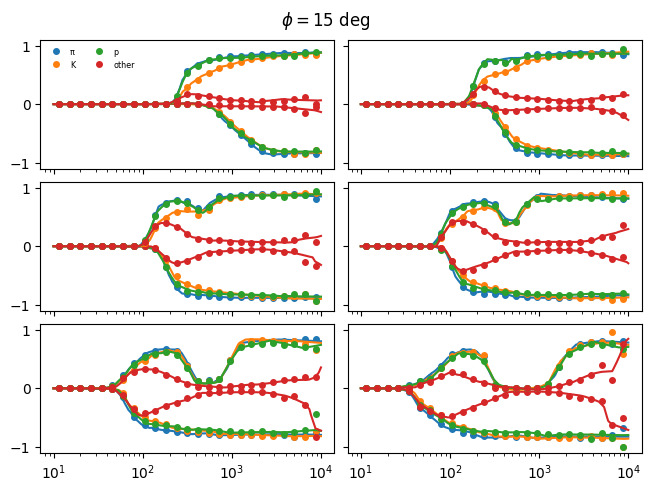

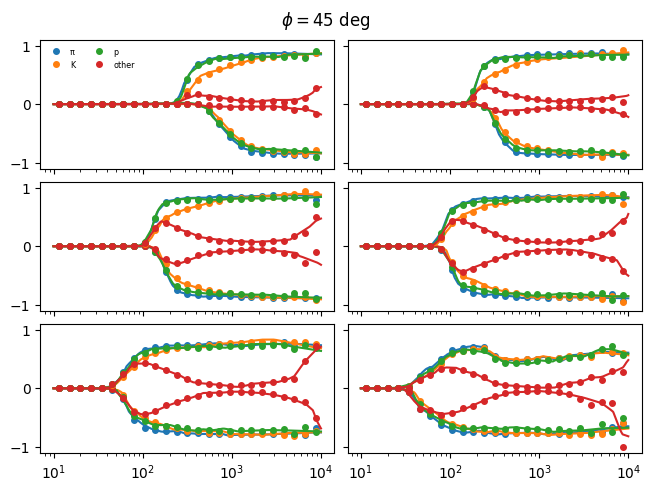

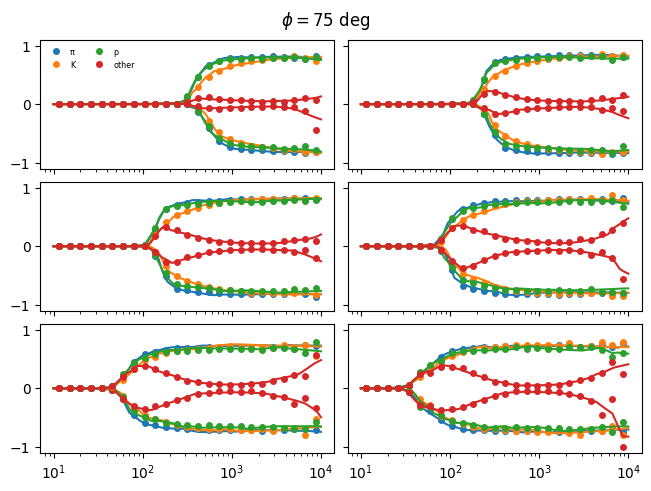

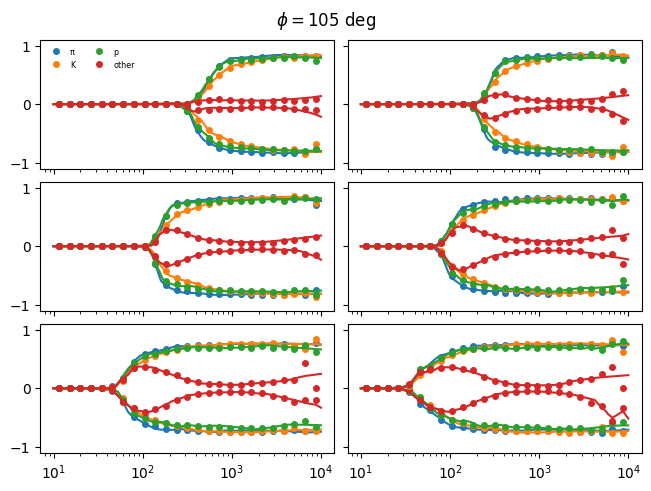

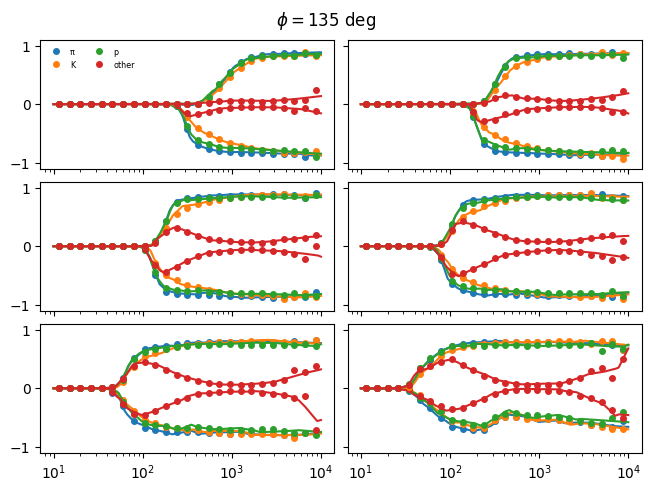

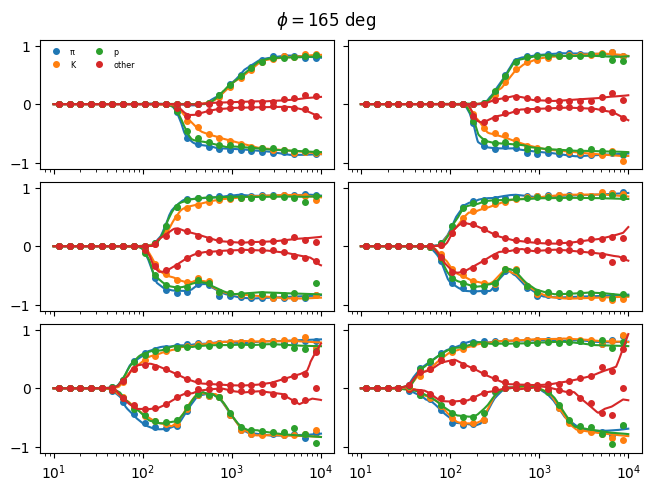

In [45]:
draw(lambda x: flax_model.apply(flax_theta, x))

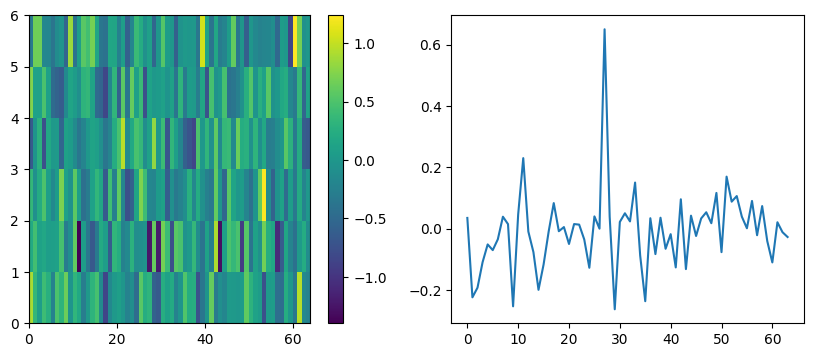

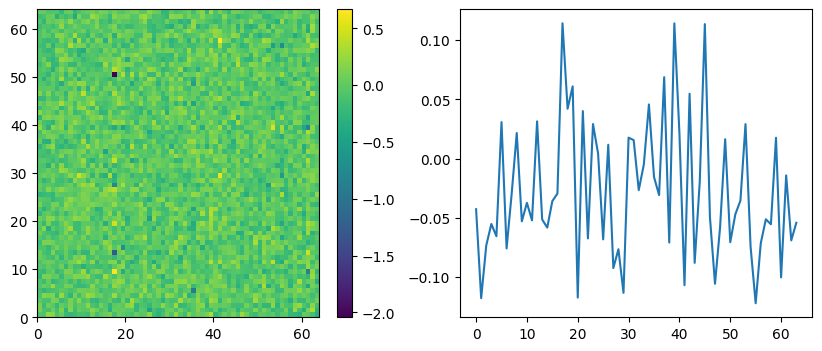

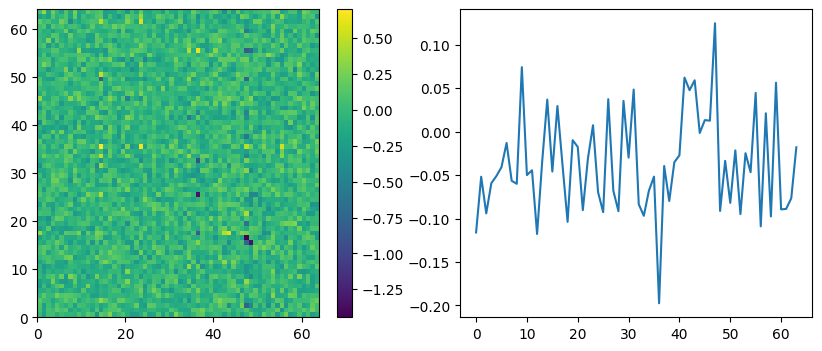

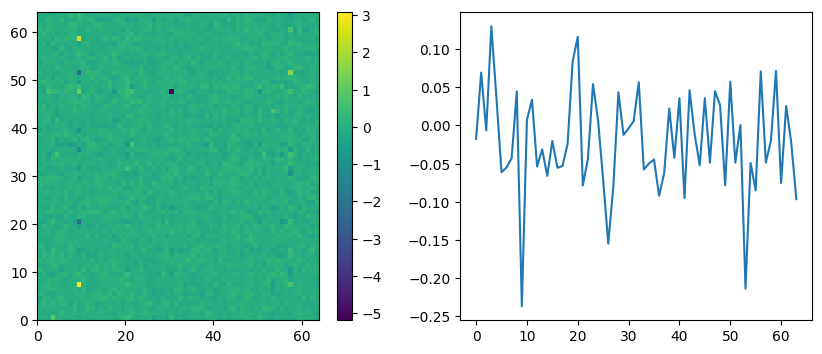

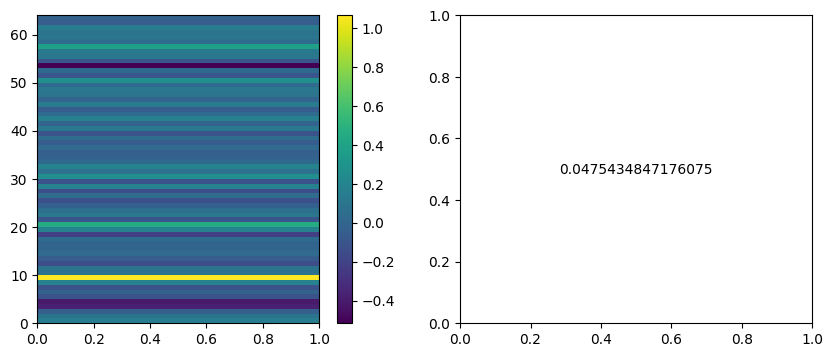

In [65]:
for layer in flax_theta["params"].values():
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    plt.sca(ax[0])
    plt.pcolormesh(layer["kernel"])
    plt.colorbar()
    if layer["bias"].shape == (1,):
        ax[1].text(0.5, 0.5, f"{layer['bias'][0]}", ha="center", va="center")
    else:
        ax[1].plot(layer["bias"])


Another version of learning with FLAX using the meta-learning technique, where the learning rate of the model optimization is learned by an outer learning step. Meta-learning outperforms our previous approach: the loss after 5000 epochs is smaller, and the run-time is a bit shorter.

epoch 1 loss=0.14738599956035614 lr=0.00970732606947422
epoch 100 loss=0.008745327591896057 lr=0.00797897670418024
epoch 200 loss=0.004240087233483791 lr=0.007569592911750078
epoch 300 loss=0.0025922127533704042 lr=0.007254528347402811
epoch 400 loss=0.002768205711618066 lr=0.007043119519948959
epoch 500 loss=0.0016362160677090287 lr=0.006843592971563339
epoch 600 loss=0.001435459009371698 lr=0.0066168843768537045
epoch 700 loss=0.0016778352437540889 lr=0.006440357305109501
epoch 800 loss=0.0010478596668690443 lr=0.006130504421889782
epoch 900 loss=0.001047196565195918 lr=0.0059621818363666534
epoch 1000 loss=0.0010347948409616947 lr=0.005817272700369358
epoch 1100 loss=0.0008638190338388085 lr=0.005676280241459608
epoch 1200 loss=0.0008743802318349481 lr=0.005501849111169577
epoch 1300 loss=0.0007698743720538914 lr=0.005327465478330851
epoch 1400 loss=0.00075662846211344 lr=0.005231064278632402
epoch 1500 loss=0.0006550266407430172 lr=0.005112390033900738
epoch 1600 loss=0.00065180164

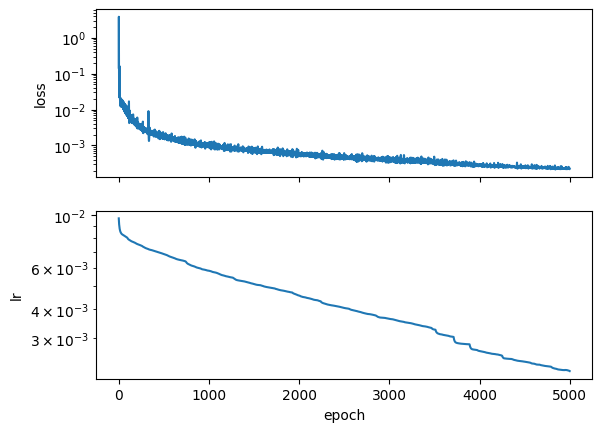

In [73]:
def train(config, x, y):
    x = jax.device_put(x)
    y = jax.device_put(y)
    model = Model(config.layers, config.nonlin)

    key1, key2, key3 = jax.random.split(jax.random.PRNGKey(0), num=3)
    theta = model.init(key1, jax.random.normal(key2, x.shape[1:]))

    opt = optax.inject_hyperparams(optax.rmsprop)(learning_rate=config.learning_rate)
    meta_opt = optax.adabelief(learning_rate=config.meta_learning_rate)

    state = opt.init(theta)
    eta = -np.log(1.0 / config.learning_rate - 1)
    meta_state = meta_opt.init(eta)

    @jax.jit
    def loss_fn(theta, x, y):
        y_pred = model.apply(theta, x)
        return jnp.mean(optax.huber_loss(y, y_pred))

    @jax.jit
    def step(theta, state, x, y):
        loss, grad = jax.value_and_grad(loss_fn)(theta, x, y)
        updates, state = opt.update(grad, state)
        theta = optax.apply_updates(theta, updates)
        return loss, theta, state

    @jax.jit
    def outer_loss(eta, theta, state, x, y):
        state.hyperparams["learning_rate"] = jax.nn.sigmoid(eta)
        loss, theta, state = step(theta, state, x[:-1], y[:-1])
        return loss_fn(theta, x[-1], y[-1]), (loss, theta, state)

    @jax.jit
    def outer_step(eta, theta, meta_state, state, x, y):
        grad, (loss, theta, state) = jax.grad(outer_loss, has_aux=True)(eta, theta, state, x, y)
        meta_updates, meta_state = meta_opt.update(grad, meta_state)
        eta = optax.apply_updates(eta, meta_updates)
        return eta, theta, meta_state, state, loss

    learning_rates = []
    losses = []

    for epoch in range(1, config.max_epoch + 1):
        key3, subkey = jax.random.split(key3)
        perm = jax.random.permutation(subkey, len(x))
        eta, theta, meta_state, state, loss = outer_step(eta, theta, meta_state, state, x[perm], y[perm])
        learning_rate = jax.nn.sigmoid(eta)

        losses.append(loss)
        learning_rates.append(learning_rate)

        if epoch == 1 or epoch % config.print_freq == 0:
            print(f"epoch {epoch} loss={loss} lr={learning_rate}")

    return model, theta, losses, learning_rates

config = ConfigDict()
config.layers = (2 ** 6,) * 4
config.nonlin = nn.relu
config.max_epoch = 5000
config.learning_rate = 1e-2
config.meta_learning_rate = 0.03
config.print_freq = 100

flax_model, flax_ml_theta, losses, learning_rates = train(config, X, y)

fig, ax = plt.subplots(2, 1, sharex=True)
ax[0].plot(losses)
ax[0].set(ylabel="loss", yscale="log")
ax[1].plot(learning_rates)
ax[1].set(xlabel="epoch", ylabel="lr", yscale="log");

In [75]:
print("MLPRegressor        ", mean_squared_error(clf.predict(X), y))
print("PyTorch             ", mean_squared_error(torch_model(torch_X).detach().numpy(), y))
print("Flax                ", mean_squared_error(flax_model.apply(flax_theta, X), y))
print("Flax (meta-learning)", mean_squared_error(flax_model.apply(flax_ml_theta, X), y))

MLPRegressor         0.0012928459
PyTorch              0.0007299928
Flax                 0.00061631005
Flax (meta-learning) 0.00044411403


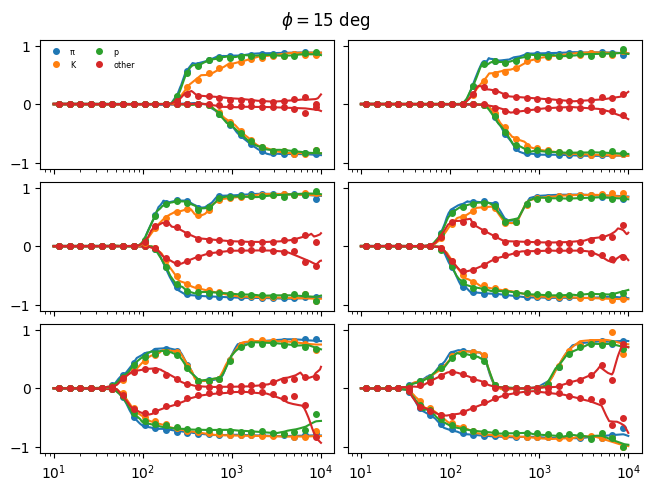

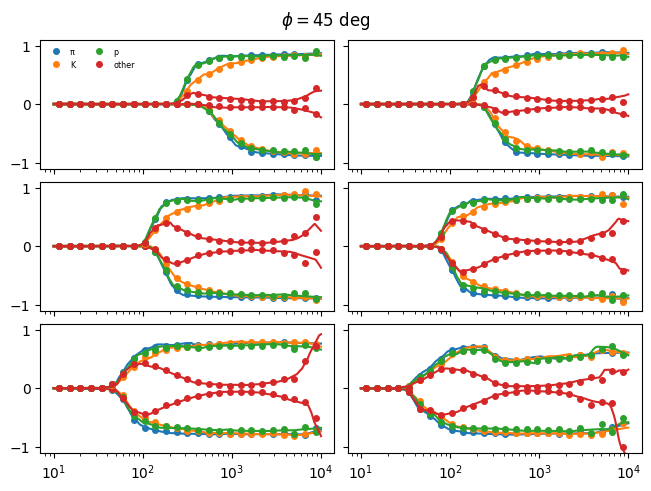

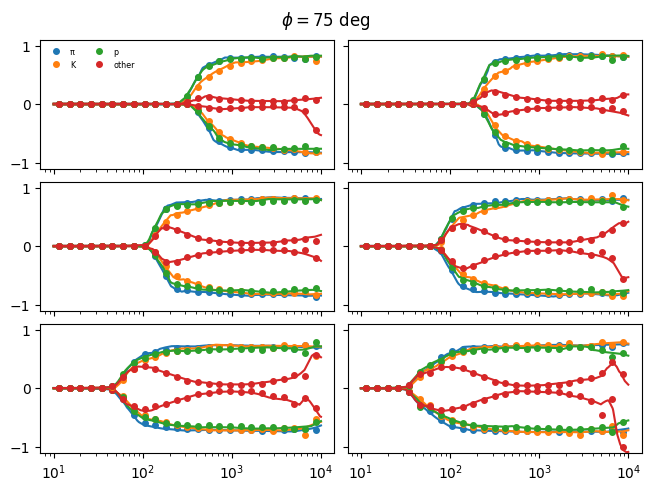

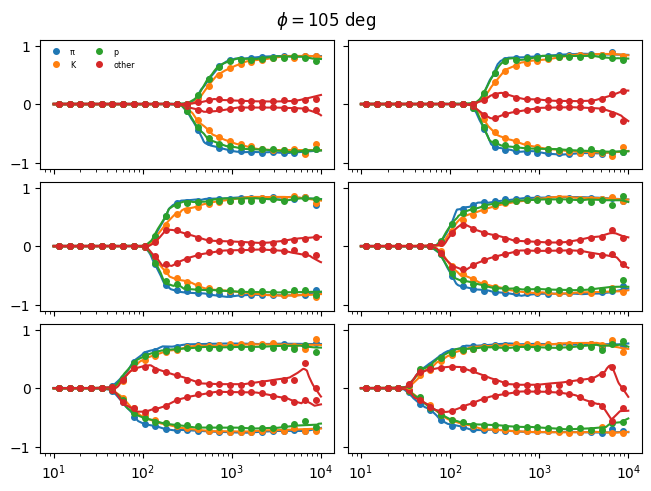

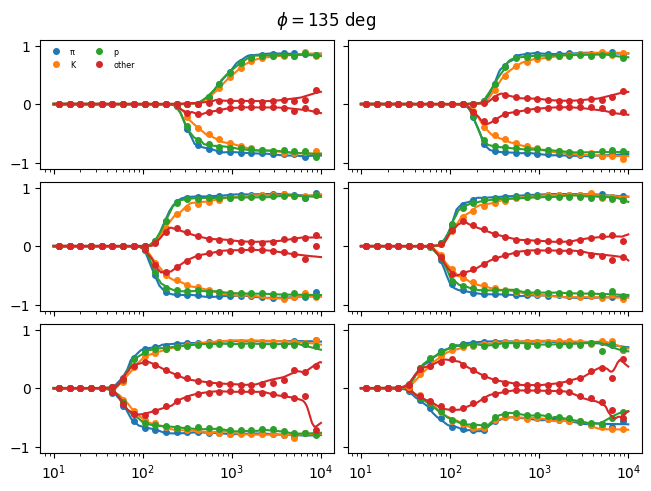

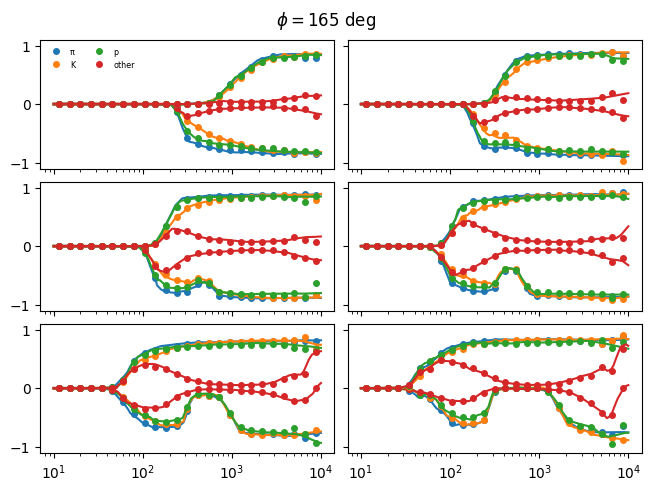

In [76]:
draw(lambda x: flax_model.apply(flax_ml_theta, x))